In [1]:
%config Completer.use_jedi = False

In [2]:
cd /home/jacob/PycharmProjects/glom-tensorflow/

/home/jacob/PycharmProjects/glom-tensorflow


In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfkl
import tensorflow_datasets as tfds
import tensorflow_probability as tfp


from src.glom import GLOM

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

warnings.filterwarnings('ignore')

### visualization functions

- `convertImageToOneHot`: don't use because real images should use sparse *distributed* representations
- `view_layer_states` simple `'e_norm'` plotter
- `NDtoRGB` linear projection
- `make_uniform` bring tensor to `[0,1)`
- `view_layer_states2` shows all layers plot `'x', 'e', 'e_norm'` and distplot for `'e_norm'`

In [29]:
def convertImageToOneHot(image, N=16):
    image = image[None, ...]
    image = image / 255.0
    image = image * N
    image = tf.cast(image, tf.int64)
    image = tf.one_hot(image, depth=N)
    image = tf.cast(image, tf.float32)

    # image = tf.tile(image[:, None, :, :, :], multiples=[1, T, 1, 1, 1])
    return image

In [30]:
def view_layer_states(layer_states):
    fig, axes = plt.subplots(1, len(layer_states))
    for (layer, state), axis in zip(layer_states.items(), axes):
        axis.imshow(state['e_norm'][0,:,:])
        axis.set_title(layer)
    plt.show()

In [31]:
def NDtoRGB(t):
    # get greatest divisor by 3
    t = tf.reshape(t[..., :3*(t.shape[-1] // 3)], 
                   t.shape[:-1] + [3, t.shape[-1] // 3])
    coefs = (tf.range(t.shape[-1], dtype=tf.float32))
    sum_coefs = tf.reduce_sum(coefs)
    return tf.reduce_sum(t * coefs / sum_coefs, axis=-1)

In [32]:
def make_uniform(t):
    minval = tf.reduce_min(t)
    maxval = tf.reduce_max(t)  
    return (t - minval) / (maxval - minval + 1e-6)

def view_layer_states2(layer_states):
    fig, axes = plt.subplots(nrows=4, ncols=len(layer_states), figsize=(7,7))

    for axes_row in axes[:-1]:
        for axis in axes_row:
            axis.xaxis.set_visible(False)
            axis.yaxis.set_visible(False)
    
    for i, (layer, state) in enumerate(layer_states.items()):
        axes[0, i].set_title(layer)
        
        x = make_uniform(NDtoRGB(layer_states[layer]['x'])[0])
        axes[0, i].imshow(x)
        
        e = make_uniform(NDtoRGB(layer_states[layer]['e'])[0])
        axes[1, i].imshow(e)
        
        e_norm = make_uniform(layer_states[layer]['e_norm'][0,:,:])
        axes[2, i].imshow(e_norm, cmap='gray')
        
        sns.distplot(tf.reshape(e_norm, (-1,)).numpy(), ax=axes[3, i])
        

    plt.subplots_adjust(wspace=.025, hspace=.025)
    plt.show()

### Load unstructured data dataset

I already have `imagenet_v2/topimages` downloaded on my laptop. I chose this dataset because of its diversity and small size (only ~1GB).

In [5]:
ds0, info = tfds.load('imagenet_v2/topimages', with_info=True)

In [6]:
BATCH_SIZE = 32
H, W = 64, 96

resize_and_rescale = keras.Sequential([
  tfkl.experimental.preprocessing.Resizing(H, W, ),
  tfkl.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = keras.Sequential([
  tfkl.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tfkl.experimental.preprocessing.RandomRotation(0.2),
])

ds = ds0['test']
ds = ds.take(1024)
ds = ds.map(lambda x: x['image'])
ds = ds.map(lambda x: resize_and_rescale(x[None, ...])[0] )
ds = ds.batch(BATCH_SIZE)
ds_copy = ds.map(lambda x: data_augmentation(x))
ds = ds.concatenate(ds_copy)
#test_ds = test_ds.map(lambda t: tf.image.resize(t, size=(H, W), preserve_aspect_ratio=False))

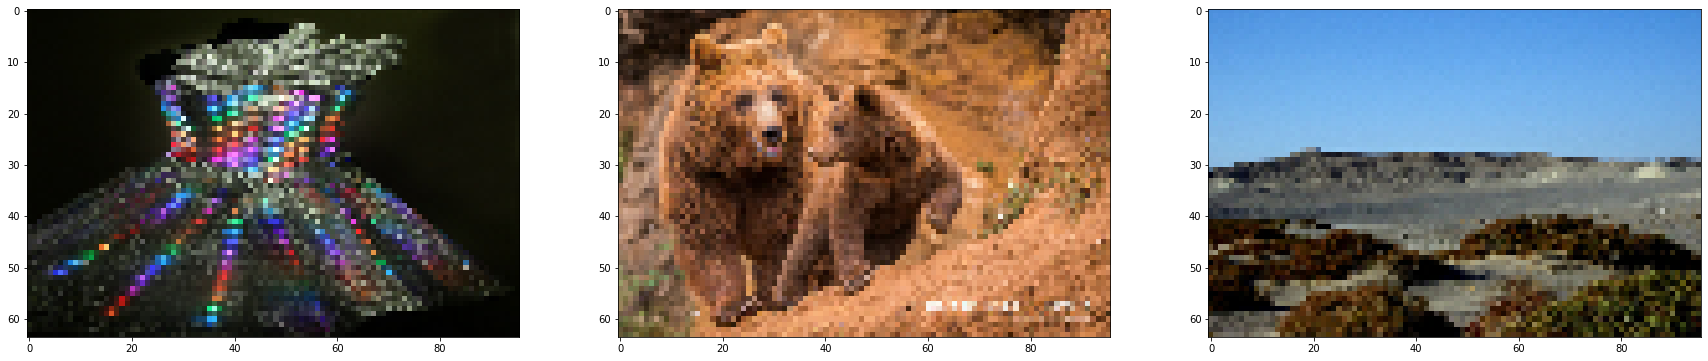

In [7]:
sample_images = next(iter(ds))
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(sample_images[0])
axes[1].imshow(sample_images[8])
axes[2].imshow(sample_images[19])

### make SDR AE for image input

In [12]:
@tf.custom_gradient
def clip01(x):
    return tf.clip_by_value(x, 0, 1), lambda g: g

256/256 [==============================] - 0s 884us/step - loss: 0.0000e+00


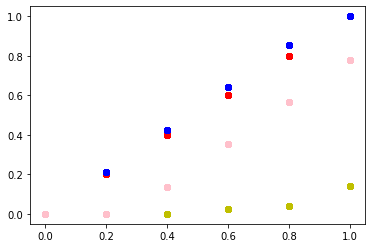

<AxesSubplot:ylabel='Density'>

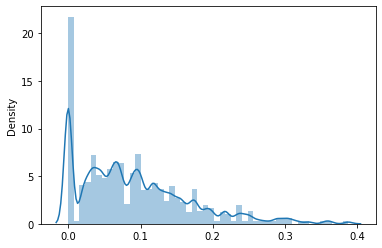

In [115]:
class SAE(keras.Model):

    def __init__(self, params):
        """params must contain:
            * d_enc
            * enc_activation
            * dec_activation
            * activation_sparsity
            * noise_coef
            * lambda_average_sparsity
            * lambda_individual_sparsity
        """
        super(SAE, self).__init__()
        
        self.p = self.params = params
        
    def build(self, input_shape):
        
        d_enc = self.p['d_enc']
        d_dec = input_shape[-1]
        
        self.W_enc = self.add_weight(name='W_enc', shape=(d_dec, d_enc), 
                                     initializer=keras.initializers.HeUniform())
        self.W_dec = self.add_weight(name='W_dec', shape=(d_enc, d_dec), 
                                     initializer=keras.initializers.HeUniform())
        
        self.rng = tfp.layers.DistributionLambda(
            make_distribution_fn=lambda t: tfp.distributions.Normal( 
                loc=tf.zeros((d_enc,)), scale=self.p['noise_coef']))
            
    def call(self, inputs, training=False):
        
        encoded = self.p['enc_activation'](inputs @ self.W_enc)
        noisy_encoded = encoded
        if training:
            noisy_encoded = noisy_encoded + self.rng(0)
        decoded = self.p['dec_activation'](noisy_encoded @ self.W_dec)
        
        if training:
            # average sparsity loss
            #average_sparsity = tf.reduce_mean(encoded)
            #average_sparsity_deviation = (average_sparsity - self.p['activation_sparsity']) ** 2
            #self.add_loss(self.p['lambda_average_sparsity'] * average_sparsity_deviation)

            # individual sparsity loss
            individual_sparsity = (encoded**2) * ((1 - encoded)**2)
            mean_individual_sparsity = tf.reduce_mean(individual_sparsity)
            self.add_loss(self.p['lambda_individual_sparsity'] * mean_individual_sparsity)

            #individual_sparsity = tf.norm(encoded, ord=1, axis=-1)
            #mean_individual_sparsity = tf.reduce_mean(individual_sparsity)
            #self.add_loss(self.p['lambda_individual_sparsity'] * mean_individual_sparsity)

            # kl average sparsity
            target_sparsity = self.p['activation_sparsity']
            # for layer units averaged over batches
            batch_ave = tf.reduce_mean(encoded, axis=0)
            batch_kld = batch_ave * tf.math.log((batch_ave+1e-3)/target_sparsity) \
                      + (1-batch_ave) * tf.math.log((1.-batch_ave+1e-3)/(1.-target_sparsity))

            # for batches averages over layer units
            layer_ave = tf.reduce_mean(encoded, axis=-1)
            layer_kld = batch_ave * tf.math.log((batch_ave+1e-3)/target_sparsity) \
                      + (1-batch_ave) * tf.math.log((1.-batch_ave+1e-3)/(1.-target_sparsity))

            combined_kld = tf.reduce_mean(batch_kld) + tf.reduce_mean(layer_kld)
            self.add_loss(self.p['lambda_average_sparsity'] * combined_kld)
        
        # for later analysis
        self.encoded = encoded
        self.decoded = decoded
        
        return decoded

sae = SAE(dict(
    d_enc=64,
    enc_activation=clip01,
    dec_activation=clip01,
    activation_sparsity=4./64.,
    noise_coef=0.5,
    lambda_average_sparsity=1,
    lambda_individual_sparsity=0,
))

sae.compile(keras.optimizers.Adam(0.02), 'mse')

X = tf.range(-0.1, 1.1, 0.01)[:, None]
X = tf.random.uniform((2**13, 1), minval=-0.1, maxval=1.1)
X = tf.round(X * 5) / 5
Y = X

plt.scatter(X, Y, c='r')

Y = sae(X)
plt.scatter(X, Y, c='y')

histories = []
for b in range(8):
    history = sae.fit(X, X, epochs=1, verbose=1)
    histories.append(history)

    Y = sae(X)
    #plt.scatter(X, Y, c='g', ax=fig.axes)
    #sns.distplot(tf.reshape(sae.encoded, (-1,)).numpy())
    
    
Y = sae(X)
plt.scatter(X, Y, c='b')
sae.evaluate(X, Y)
Y = sae(X, training=True)
plt.scatter(X, Y, c='pink')
plt.show()
sns.distplot(tf.reshape(sae.encoded, (-1,)).numpy())

In [98]:
sae.losses, sae.encoded[0:4]

([<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.054081954>],
 <tf.Tensor: shape=(4, 64), dtype=float32, numpy=
 array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

In [53]:
X[100:104], sae.encoded[100:104, :16]

(<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[0.6],
        [0.8],
        [0. ],
        [1. ]], dtype=float32)>,
 <tf.Tensor: shape=(4, 8), dtype=float32, numpy=
 array([[0.07146344, 0.062719  , 0.07249352, 0.06956962, 0.06572209,
         0.06748067, 0.07395483, 0.06950714],
        [0.09528458, 0.08362533, 0.09665801, 0.09275949, 0.08762946,
         0.08997422, 0.09860644, 0.09267619],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.11910573, 0.10453166, 0.12082252, 0.11594936, 0.10953682,
         0.11246778, 0.12325805, 0.11584523]], dtype=float32)>)

### Make SDR for image input

This is more 'real' data than random uniform

In [9]:
def show_samples(sparse_rgb_ae, ofset=0):
    N_samples = 2
    sample_origonals = sample_images[ofset:ofset+N_samples]
    sample_shape = sample_origonals.shape
    sample_origonals = tf.reshape(sample_origonals, shape=(-1, 3))
    sample_reconstructions = sparse_rgb_ae(sample_origonals)
    sample_origonals = tf.reshape(sample_origonals, shape=sample_shape)
    sample_reconstructions = tf.reshape(sample_reconstructions, shape=sample_shape)
    fig, axes = plt.subplots(N_samples, 2, figsize=(2*5, N_samples*5))
    for i in range(N_samples):
        axes[i, 0].imshow(sample_origonals[i])
        axes[i, 1].imshow(sample_reconstructions[i])
    plt.show()

train_ds = ds.take(32) \
             .map(lambda x: tf.reshape(x, (-1, x.shape[-1]))) \
             .map(lambda x: (x, x))

In [19]:
def loss(x):
    sparsity=0.2
    x = clip01(x*1.05-0.025)
    indv_loss = (x**0.26)*((1-x)**1)
    loss = tf.reduce_mean(indv_loss)
    ave = tf.reduce_mean(x, axis=0)
    kld = ave * tf.math.log((ave+1e-3)/sparsity) \
        + (1-ave) * tf.math.log((1-ave+1e-3)/(1-sparsity))
    loss = loss + tf.reduce_mean(kld)
    return loss

X = tf.Variable([0., 1., 0.2, 0.1, 0.5])
Y = loss(X)
X.numpy(), Y.numpy()

(array([0. , 1. , 0.2, 0.1, 0.5], dtype=float32), 0.34925604)

In [24]:
BinaryRegularizer()(tf.Variable([0.1, 0.2, 0.4]))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.16333334>

In [109]:
tf.sparse.from_dense(Wd).values

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2. , 1. , 0.2], dtype=float32)>

In [142]:
def threshold(x, bar=0.1):
    m = tf.cast(x >= bar, tf.float32)
    return x

Ws = tf.sparse.SparseTensor(
     indices=[(0,0), (1,2), (3,0)],
     values=[2., 1., 0.2],
     dense_shape=(4,3))
Wd = tf.sparse.to_dense(Ws)
X = tf.Variable([[0.1, 0, 0.3, 0.9]])
Y = tf.Variable([[1., 5., 0.]])

with tf.GradientTape(persistent=True) as tape:
    tape.watch(X)
    tape.watch(Wd)
    hs = tf.sparse.sparse_dense_matmul(X, Ws)
    ys = tf.nn.relu(hs)
    Es = tf.reduce_mean((ys - Y) ** 2)
    hd = X @ Wd
    yd = tf.nn.relu(hd)
    Ed = tf.reduce_mean((yd - Y) ** 2)

dyd_dx = tape.gradient(Ed, X)
dys_dx = tape.gradient(Es, X)
dEd_dWd = tape.gradient(Ed, Wd)
# custom sparse backpropagation
dEs_dhs = tape.gradient(Es, hs)
dense_dEs_dWs = tf.transpose(X) @ dEs_dhs
dEs_dWs = -threshold(-dense_dEs_dWs, bar=0.0)
dEs_dWs = tf.sparse.from_dense(-0.1 * dEs_dWs)
#dEs_dWs = tf.sparse.from_dense(dEs_dWs)
del tape

#tf.print(dys_dx, dyd_dx)
tf.print(tf.sparse.to_dense(dEs_dWs))
tf.print(dEd_dWd)

# update weights
Wd = Wd - 0.1 * dEd_dWd

tf.sparse.add(Ws, dEs_dWs, 0.1)

tf.print(tf.sparse.to_dense(Ws))
tf.print(Wd)

[[0.00413333392 0 0]
 [0 0 0]
 [0.0124000013 0 0]
 [0.0372 0 0]]
[[-0.0413333364 0 0]
 [0 0 0]
 [-0.124000013 0 0]
 [-0.372 0 0]]
[[2 0 0]
 [0 0 1]
 [0 0 0]
 [0.2 0 0]]
[[2.00413322 0 0]
 [0 0 1]
 [0.0124000013 0 0]
 [0.2372 0 0]]


2045/2045 [==============================] - 2s 788us/step - loss: 0.0499


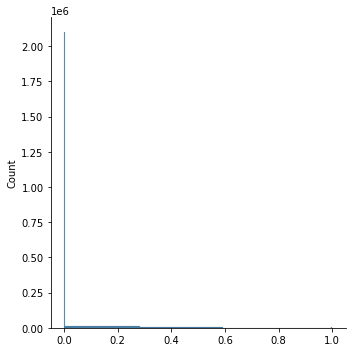

2045/2045 [==============================] - 3s 2ms/step - loss: 0.0477


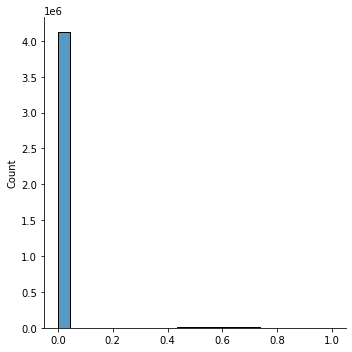

In [143]:
def make_spare_rgb_ae():
    return SAE(dict(
        d_enc=64,
        enc_activation=clip01,
        dec_activation=clip01,
        activation_sparsity=6./64.,
        noise_coef=0.2,
        lambda_average_sparsity=1,
        lambda_individual_sparsity=1,
    ))
# sparse_rgb_ae = make_spare_rgb_ae()

class BinaryRegularizer(keras.regularizers.Regularizer):
    
    def __init__(self):
        pass
    
    def __call__(self, x):
        return tf.reduce_mean(x * (1-x))
    
class BinarySquaredRegularizer(keras.regularizers.Regularizer):
    
    def __init__(self):
        pass
    
    def __call__(self, x):
        return tf.reduce_mean(x**2 * (x-1) ** 2)
    
class DoubleWellRegularizer(keras.regularizers.Regularizer):
    
    def __init__(self):
        pass
    
    def __call__(self, x):
        return tf.reduce_mean(x**2) + tf.reduce_mean((x-1)**2)
    
class BinaryKLRegularizer(keras.regularizers.Regularizer):
    
    def __init__(self, sparsity):
        self.sparsity=sparsity
    
    @tf.function
    def __call__(self, x):
        x = clip01(x*1.05-0.025)
        indv_loss = (x**0.26)*((1-x)**1)
        loss = tf.reduce_mean(indv_loss)
        ave = tf.reduce_mean(x, axis=0)
        kld = ave * tf.math.log((ave+1e-3)/self.sparsity) \
            + (1-ave) * tf.math.log((1-ave+1e-3)/(1-self.sparsity))
        loss = loss + 0.1 * tf.reduce_mean(kld)
        return loss        
    
class JacobInitializer(keras.initializers.Initializer):
    
    def __call__(self, shape, dtype=None, **kwargs):
        # returns a tensor of shape `shape` and dtype `dtype`
        # containing values drawn from a distribution of your choice.
        pass
    
D = 1000

def make_sequential_ae():
    return keras.Sequential([
        tfkl.Dense(64, activation=clip01, use_bias=False,
                   #activity_regularizer=BinaryRegularizer()
                  ),#kernel_initializer=keras.initializers.Initializer()),
        tfkl.Dense(D, activation='relu', use_bias=False),
    ])
sparse_rgb_ae = make_sequential_ae()

def elementwise_loss(ytrue, ypred):
    diff = ytrue - ypred
    return tf.reduce_mean(diff ** 2)

sparse_rgb_ae.compile(keras.optimizers.Adam(0.005), loss=elementwise_loss)

X = tf.random.uniform((2**16, D))
X = tf.cast(X > 0.95, tf.float32)
Xtrain=X[:-100]
Xtest=X[-100:]
sparse_rgb_ae.evaluate(Xtrain, Xtrain)
sparse_rgb_ae.layers[0].weights[0].assign(1*sparse_rgb_ae.layers[0].weights[0])

def test_enc_sparsity():
    enc_test = tf.reshape(sparse_rgb_ae.layers[0]( Xtrain ), (-1,))
    sns.displot(enc_test)
    plt.show()

test_enc_sparsity()
    
#show_samples(sparse_rgb_ae)
for b in range(4):
    history = sparse_rgb_ae.fit(Xtrain, Xtrain, epochs=1)
#show_samples(sparse_rgb_ae)
    
test_enc_sparsity()

<AxesSubplot:ylabel='Density'>

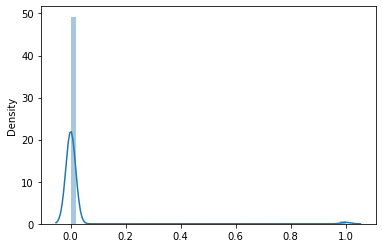

In [59]:
Xtest = tf.random.uniform((256,D))
Xtest = tf.round(Xtest)#next(iter(train_ds))[0][:1000]
enc_test = sparse_rgb_ae.layers[0]( Xtest )
enc_test_flat = tf.reshape(enc_test, (-1,))
sns.distplot(enc_test_flat)

In [60]:
X[0]

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 

In [38]:
axis_mean = tf.reduce_mean(enc_test, axis=0)
axis_mean.numpy().round(1)

array([0.7, 0. , 0. , 0. , 0.4, 1. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 1. , 0. , 0. , 0. , 0. ,
       0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0.4, 0. ,
       1. , 0.3, 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0.2, 0. ],
      dtype=float32)

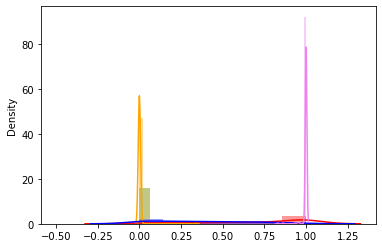

InvalidArgumentError: Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: strided_slice/

In [33]:
sns.distplot(enc_test[:, 0], color='red')
sns.distplot(enc_test[:, 1], color='orange')
sns.distplot(enc_test[:, 2], color='yellow')
sns.distplot(enc_test[:, 3], color='green')
sns.distplot(enc_test[:, 4], color='blue')
sns.distplot(enc_test[:, 5], color='violet')
sns.distplot(enc_test[:, 7], color='pink')
plt.show()

Y[0:3, :].numpy()

This is not the kind of sparse autoencoding I was imagining. It's because I forgot to add the KL divergence penalty.

8/8 [==============================] - 0s 19ms/step - loss: -0.5662


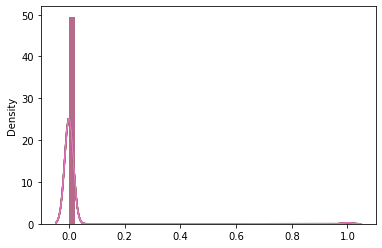

In [97]:
class SparseLayer(tfkl.Layer):
    """params
    * d_enc
    * mu_input
    * mask_sparsity
    * activity_beta
    """
    
    PARAM_DEFAULTS = dict(
        top_k=10,
        d_enc=1024,
        mu_input=0.1,
        mask_sparsity=0.1,
        activity_beta=0.02
    )
    
    def __init__(self, params):
        super(SparseLayer, self).__init__()
        self.params = self.PARAM_DEFAULTS.copy()
        self.params.update(params)
        self.p = self.params
        
        self._batch_size = 0

    def build(self, input_shape):
        d_in = input_shape[-1]
        
        self.W = self.add_weight(name='W', shape=(d_in, self.p['d_enc']))
        #self.W = tf.Variable(tf.ones((d_in, self.p['d_enc']))) # self.add_weight(shape=(d_in, self.p['d_enc']))
        #self.W = self.W / (self.p['mask_sparsity'] * self.p['mu_input'])
        
        rnd_mask = tf.random.uniform(self.W.shape) < self.p['mask_sparsity']
        self.rnd_mask = tf.cast(rnd_mask, tf.float32)
        
    @tf.function
    def call(self, x):
        a = x @ (self.W * self.rnd_mask)
        
        activity = self._get_activity(x.shape[0])
        #a_boosted = a * tf.exp(-activity)
        a_boosted = a - activity
        
        """@tf.custom_gradient
        def diff_topk(a_boosted):
            top_indices = tf.argmax(a_boosted, axis=-1)
            top_mask = tf.one_hot(top_indices, a_boosted.shape[-1], axis=-1)
            
            def gradient(grad):
                return a_boosted * top_mask
            
            return top_mask, gradient"""
        
        # this is simpler since we should be trying to approach 0 or 1 anyway
        # since top_k returns a vector of top entities, and ones_hot gives each
        # index its own 3D row, we must reduce_sum the rows to get a composite mask
        _, top_indices = tf.math.top_k(a_boosted, k=self.p['top_k'], sorted=False)
        top_mask = tf.one_hot(top_indices, a_boosted.shape[-1], axis=1)
        top_mask = tf.reduce_sum(top_mask, axis=-1)  
            
        y = a_boosted * top_mask
        #tf.print(a_boosted - a, summarize=10)
        self._set_activity(y)
        
        @tf.custom_gradient
        def mask():
            def g(grads):
                return top_mask * g
            return top_mask, g
        
        return tf.custom_gradient(lambda : (top_mask, (lambda grads: grads * top_mask)))()
        
    def _get_activity(self, batch_size):
        if self._batch_size != batch_size:
            self._batch_size = batch_size
            self._activity = tf.zeros((self.p['d_enc'],), name="activity")
        return self._activity
    
    def _set_activity(self, activity):
        beta = self.p['activity_beta']
        #self._activity = (1-beta) * self._activity - beta * activity
        self._activity = beta * activity + (1-beta) * self._activity
        self._activity = tf.stop_gradient(self._activity)

D = 2048
X = tf.random.uniform((2**8, D))
X = tf.cast(X >= 0.8, tf.float32)
mu_X = tf.reduce_mean(X)

sae3 = keras.Sequential([
    tfkl.Input(shape=(D,)),
    SparseLayer(dict(
        top_k=64,
        d_enc=1024,
        mu_input=mu_X,
        mask_sparsity=0.2,
        activity_beta=5.)),
    SparseLayer(dict(
        top_k=32,
        d_enc=2048,
        mu_input=mu_X,
        mask_sparsity=0.1,
        activity_beta=8)),
    tfkl.Dense(D, 'relu', use_bias=False)
])

opt = keras.optimizers.Adam(0.01)
sae3.compile(opt, keras.losses.CosineSimilarity())

for b in range(20):
    sae3.fit(X, X, verbose=0)
    
    if b % 3 == 0:
        sae3.evaluate(X, X, verbose=1)
        sns.distplot(sparse_layer(X[:10]))

plt.show()

In [38]:
import numpy as np

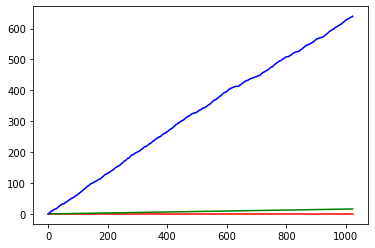

In [98]:
X = tf.random.uniform((2**10, D))

Y = sae3.layers[0](X)
Y = sae3.layers[1](Y)
#Y = sae3.layers[2](Y)

probe_depth = Y.shape[0]

mean_overlaps = np.zeros((probe_depth,))
max_overlaps = np.zeros((probe_depth,))
min_overlaps = np.zeros((probe_depth,))

depths = tf.range(probe_depth)

for d in depths:
    overlaps = tf.reduce_sum(Y[:d], axis=0)
    min_overlaps[d] = tf.reduce_min(overlaps)
    mean_overlaps[d] = tf.reduce_mean(overlaps)
    max_overlaps[d] = tf.reduce_max(overlaps)
    
plt.plot(depths, 1000*min_overlaps, 'r')
plt.plot(depths, mean_overlaps, 'g')
plt.plot(depths, max_overlaps, 'b')

In [100]:
min_overlaps[-1]

0.0

In [64]:
glom.summary()

Model: "glom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L0-L1 (ManyToManyDense)      multiple                  0         
_________________________________________________________________


ValueError: You tried to call `count_params` on L1-L2, but the layer isn't built. You can build it manually via: `L1-L2.build(batch_input_shape)`.

image 0: b'/home/jacob/tensorflow_datasets/downloads/extracted/TAR_GZ.s3-us-west-2_imagene_imagene-top-imagesheSs4w8_DWYBUgYiVLh1ndpmJnsn9-wP2NV2jxBzoEs.tar.gz/imagenetv2-top-images-format-val/601/088bc46ad752e10f0e3fbe2c6dbafbb3bad3b4d9.jpeg'
t:0


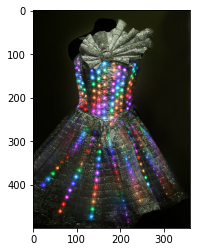

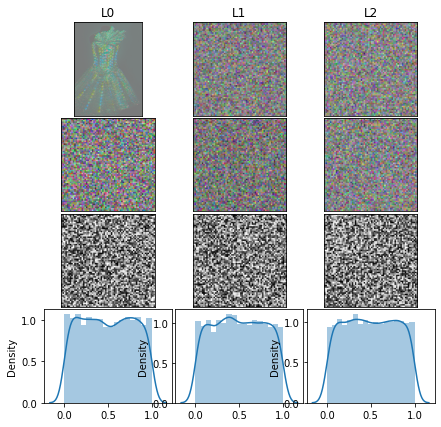

1


AssertionError: 

In [62]:
N_images = 2
T = 20

glom = GLOM(
    input_layers=['L0'],
    output_layers=['L0'],
    layer_sizes=dict(L0=(64, 64, 16), 
                     L1=(64, 64, 64), 
                     L2=(64, 64, 64)),
    connections=[
        dict(inputs=['L0'], outputs=['L1'], type='bu'),
        dict(inputs=['L1'], outputs=['L2'], type='bu'),
        dict(inputs=['L2'], outputs=['L0'], type='td'),
        #dict(inputs=['L1'], outputs=['L0'], type='td'),
    ],
    hparams=dict(
        a_bu=0.5,
        b_bu=0.,
        a_lat=1.0,
        b_lat=0.,
        a_td=0.2,
        b_td=0.,
        lr_awake=0.02,
        lr_asleep=0.005,
    ),
    name='glom'
)
glom.set_mode('awake')


layer_state_series = [glom.get_initial_state()]

for i, ex in enumerate(test_ds.take(N_images)):
    print(f'image {i}: {ex["file_name"].numpy()}')
    train_image = ex['image']
    plt.imshow(train_image)
    
    
    train_image = tf.cast(train_image, tf.float32)
    train_image = train_image / 255.
    train_image = train_image[None, ...]
    enc_train_image = encoder(train_image)
    
    for t in range(T):
        layer_state_series.append(layer_state_series[-1])
        layer_state_series[-1]['L0']['x'] = enc_train_image
        
        print(f't:{t}')
        view_layer_states2(layer_state_series[-1])
        layer_state_series[-1] = glom(layer_state_series[-1])

In [15]:
L0 = layer_state_series[1]['L0']
L1 = layer_state_series[1]['L1']
L2 = layer_state_series[1]['L2']

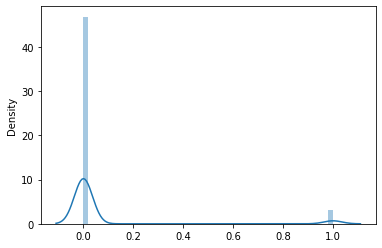

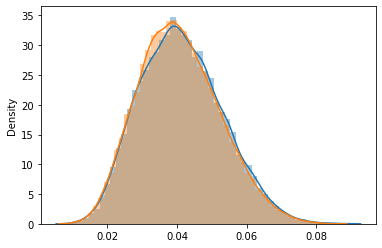

In [16]:
distplot(L0['x'])
plt.show()
distplot(L1['x']) 
distplot(L2['x'])